An application to alert household inhabitants on non normal electricty cunsomption

based on their previous consumption habits.

# Data Presentation

Data used is this notebook are energy consumption per hour in a household, for 4 years.
They were registered in a household in Sceaux.

Data are available here : https://archive.ics.uci.edu/ml/datasets/Individual+household+electric+power+consumption

For this study, I decided to focus on consumption data, excluding data relatived to voltage, intensity or reactive energy.

Ramining variable were :

**global_active_power**   : household global minute-averaged active power (in kilowatt).   
**sub_metering_1**        : kitchen :  a dishwasher, an oven and a microwave.   
**sub_metering_2**        : laundry room : a washing-machine, a tumble-drier, a refrigerator and a light.   
**sub_metering_3**        : a water-heater and an air-conditioner.   


In [33]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from datetime import datetime
import requests, json
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

import sklearn.metrics
from sklearn.metrics import mean_absolute_error

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
plt.style.use('ggplot') 



np.random.seed(53) # for reproductible results

# Load Data

In [34]:
# load the data and return a dataframe with datetime as index

dataset = pd.read_csv('household_power_consumption.txt', sep=';',
                      header=0, # line 0 has the names for the columns
                      low_memory=False, 
                      infer_datetime_format=True, 
                      parse_dates={'date_time_idx':[0,1]}, # collect date and time in one column
                      index_col=['date_time_idx']
                     )

# Prepare and enrich Data

Data were cleaned and preprocessed as following :

1 - ensure that all data are numerical : somme records included "?" for missing values. I replaced "?" by NaN values and deleted records with no value at all in our 4 variables of interest. 

2 - For each record, extract from the datetime information the month, the week, the day of week and the hour. These informations will prove interesting to show the periodic evolution of energy consumption.

3 - extract the part of energy consumption remaining when we substract the sum of Sub_metering 1, 2 and 3 from global consumption. I named this new variable "Sub_metering_4".

4 - add temperature variable. As we will see that this household seems to have an electrical heating, I added the minimum and maximum temperature recorded in the city Sceaux for each record.



# Explore consumption

In [35]:
dataset.head(10)

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
date_time_idx,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
2006-12-16 17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2006-12-16 17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
2006-12-16 17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
2006-12-16 17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0
2006-12-16 17:29:00,3.520,0.522,235.020,15.000,0.000,2.000,17.0
2006-12-16 17:30:00,3.702,0.520,235.090,15.800,0.000,1.000,17.0
2006-12-16 17:31:00,3.700,0.520,235.220,15.800,0.000,1.000,17.0
2006-12-16 17:32:00,3.668,0.510,233.990,15.800,0.000,1.000,17.0


In [36]:
def prepare_data(df) :
    
    """
    clean and enrich data for vizualisation
    
    """
       
    columns = ['Global_active_power', 'Sub_metering_1','Sub_metering_2', 'Sub_metering_3' ]

    for column in columns :
        df[column] = pd.to_numeric(df[column], errors='coerce')
    df = df.dropna(how='all')
    
    df = df.resample('D').sum()

    # add calendar columns
    df['date_time'] = df.index
    df['Day'] = df['date_time'].dt.weekday
    df['Week'] = df['date_time'].dt.week
    df['Month'] = df['date_time'].dt.month
    
    # extract remaining energy consumption
    df['Sub_metering_4'] = df['Global_active_power']*1000/60 - df['Sub_metering_1'] - df['Sub_metering_2'] - df['Sub_metering_3']
    df['Total'] = df['Global_active_power']*1000/60
    
    # add min_temperature and max_temperature of the day
    df = df.join(df_temperatures, on = df.date_time)       
    
    return df

    

In [37]:
df_temperatures = pd.read_csv('daily_temperatures.csv').set_index('time')
df_temperatures.index = pd.to_datetime(df_temperatures.index)

df = prepare_data(dataset)

## Visualize data

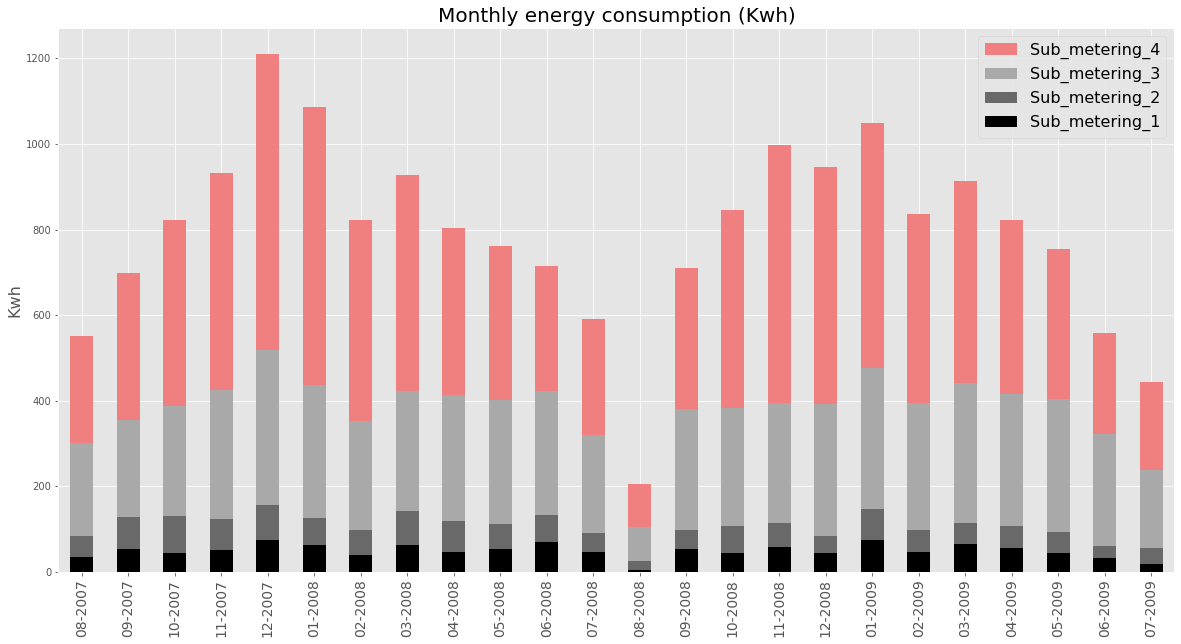

In [38]:
df_plot = df[(df.index > '2007-08-01') & (df.index < '2009-07-31')].copy()

df_plot = df_plot[['Sub_metering_1','Sub_metering_2','Sub_metering_3','Sub_metering_4' ]]/1000
df_plot = df_plot.resample('M').sum()


fig, ax = plt.subplots(figsize=(20,10))
df_plot.index = df_plot.index.strftime("%m-%Y")
df_plot.plot(ax=ax,kind='bar',color = ['black', 'dimgrey', 'darkgrey', 'lightcoral'],stacked=True)
plt.title('Monthly energy consumption (Kwh)', fontsize=20)

ax.set_ylabel('Kwh', fontsize=16)

handles, labels = plt.gca().get_legend_handles_labels()
order = [3,2,1,0]

plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], fontsize=16)



plt.xticks(fontsize=14)

plt.show()
#ax.xaxis.set_ticklabels(df_plot.index.to_period('M'))

On this figure we can see that :

- **Sub_metering_4 is the main part of energy consumption for this household**
- Sub_metering_4 presents a seasonal effect with maximum in cold winters

**We can assume that Sub_metering_4 includes an electrical heating**.

Since Sub_metering_4 is the main energy expense for the household, it could be interesting to **offer this customer a service which will alert him/her when the consumption grows higher than the usual measure**.

Indeed, causes for overconsumption in heating could come from :

- councious change in inhabitants habits : one inhabitant doesn't work anymore, is staying more often at home
- unconscious change in inhabitants habits : one has increased the thermostat and forgot to decrease it. The familiy has gotten used to live with a higher temperature at home.
- maintenance needed : the heating thermostat is not working properly anymore, or the living room sliding door is not perfectly closed anymore.

For the second last items , the inhabitants could be gratefull to be alerted so that she/he can take actions.


# Modelize anomaly detection

We will raise an anomaly when 

- the actual consumption is greater than the usual consumption, 
- the difference between actual and usual is greater than a threshold.

First we need to modelize the usual consumption.

I trained a decision tree which as learned the Sub_metering_4 cunsumption habits for this household, 

- with a granularity level on day
- with a decision tree algorithm based on the folling variables :

    - min_temperature of the day
    - max_temperature of the day
    - week
    - day of week

and the variable to be learned is Sub_metering_4

# preprocess data for machine learning

I aggregated the data with a granularity on the Day.

and encoded the categorical data as following :

1 - OneHotEncoding for Day of Week

2 - transform cyclical variables   
Since 52th week is not far from 1rst , I choose to transform the week variable into cosinus and sinus variable, as on a clock which would run one turn in 52 weeks. 

In [39]:
def encode_data(df) :
    """
    prepare data for training and predictions
    
    """
        
    df = df.reset_index(drop=True)

    # encode days  
    ohe_days = pd.DataFrame(days_encoder.transform(df[['Day']]))
    df = pd.concat([df, ohe_days],axis=1)
    
    df = df.set_index('date_time', drop=False)

    # encode cyclical variables
    df['week_sin'] = np.sin((df.Week)*(2.*np.pi/52))
    df['week_cos'] = np.cos((df.Week)*(2.*np.pi/52))
                            
    return df
    

# train our model

For the training, I selected 1 year of data from 01/08/2007 to 31/07/2008

In [40]:
X_train = dataset.loc['2007-08-01 00:00:00':'2008-07-31 00:00:00'].copy()

X_train = prepare_data(X_train)

# fit day encoder
days_encoder = OneHotEncoder(sparse=False)
days_encoder.fit(X_train[['Day']])

X_train = encode_data(X_train)
y_train = X_train['Sub_metering_4']

features = ['week_sin', 'week_cos','min_temperature','max_temperature'] + days_encoder.categories_[0].tolist()
X_train = X_train[features]



In [41]:
# Set the parameters by cross-validation
parameters_grid = [{'max_depth' : [3,5,7]}]

reg = GridSearchCV(DecisionTreeRegressor(), parameters_grid, return_train_score=True)

reg.fit(X_train,y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse',
                                             max_depth=None, max_features=None,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             presort='deprecated',
                                             random_state=None,
                                             splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid=[{'max_depth': [3, 5, 7]}], pre_dispatch='2*n_jobs',
             refit=True, return_train_score=True, scoring=None, verbose=0)

In [42]:
reg.best_params_

{'max_depth': 3}

In [43]:
reg.cv_results_

{'mean_fit_time': array([0.00380521, 0.00259051, 0.00238776]),
 'std_fit_time': array([0.00040506, 0.00080088, 0.0004992 ]),
 'mean_score_time': array([0.00199957, 0.00120025, 0.00120869]),
 'std_score_time': array([0.00063106, 0.00040171, 0.00042122]),
 'param_max_depth': masked_array(data=[3, 5, 7],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'max_depth': 3}, {'max_depth': 5}, {'max_depth': 7}],
 'split0_test_score': array([-0.27958423, -0.48968088, -0.88514229]),
 'split1_test_score': array([-0.22566084, -0.42219145, -2.81041668]),
 'split2_test_score': array([-0.05756715, -0.0997887 , -0.07162869]),
 'split3_test_score': array([-0.93784023, -1.73278472, -1.65482327]),
 'split4_test_score': array([-0.52480743, -0.05260358, -0.1772202 ]),
 'mean_test_score': array([-0.40509198, -0.55940986, -1.11984622]),
 'std_test_score': array([0.30557282, 0.61132705, 1.01849091]),
 'rank_test_score': array([1, 2, 3]),
 'split0_train_s

# Measure performance
How is our model capable to predict the energy consumption on next year ?
We measure the performance on our model on new data : from 01/08/2008 to 31/07/2009

In [44]:
X_test = dataset.loc['2008-08-01 00:00:00':'2009-07-31 00:00:00'].copy()



X_test = prepare_data(X_test)

X_test = encode_data(X_test)
y_test = X_test['Sub_metering_4']

#keep time indexes for further use
X_test_timeindexes = X_test['date_time']

X_test = X_test[features]


In [45]:
predictions = reg.predict(X_test)

In [46]:
predictions_mae = mean_absolute_error(y_test, predictions)
print("The Mean absolute error on predicted Sub_metering_4 cunsomption for a day {} Kwh".format(int(predictions_mae/1000)))

The Mean absolute error on predicted Sub_metering_4 cunsomption for a day 3 Kwh


# Detect anomalies

We don't want to alert a customer whenever he/she ugrades his temperature comfort for only a day. I propose to alert the customer only if the overconsumption is cumulated over a week. 

I compute the actual energy consumption and the predicted (= "usual") consumption for a rolling window of 7 days.

How to set the anomaly threshold ?
Some method are based on the distribution on the prediction error.
Nevertheless , the threshold has to be tuned based on the customer needs.

I chose a threshold equal to 15kwh (easier to communicate)

In [47]:
df_results = pd.DataFrame(X_test_timeindexes, columns = ['date_time'])
df_results['Actuals'] = y_test.values
df_results['Predicted'] = predictions
df_results['Error'] = df_results['Actuals'] - df_results['Predicted']

df_results = df_results.set_index('date_time')

df_results = df_results.rolling(7).sum()

anomaly_threshold = df_results.Error.quantile(0.95)

In [48]:
anomaly_threshold

18989.9803630952

In [49]:
anomaly_threshold = 15000

# Visualize Anomalies

In [50]:
start = '2008-06-30'
end='2009-07-31'

df_results = df_results[(df_results.index > start) & (df_results.index < end)]
df_anomalies = df_results[df_results['Error'] > anomaly_threshold][['Error','Actuals','Predicted']]

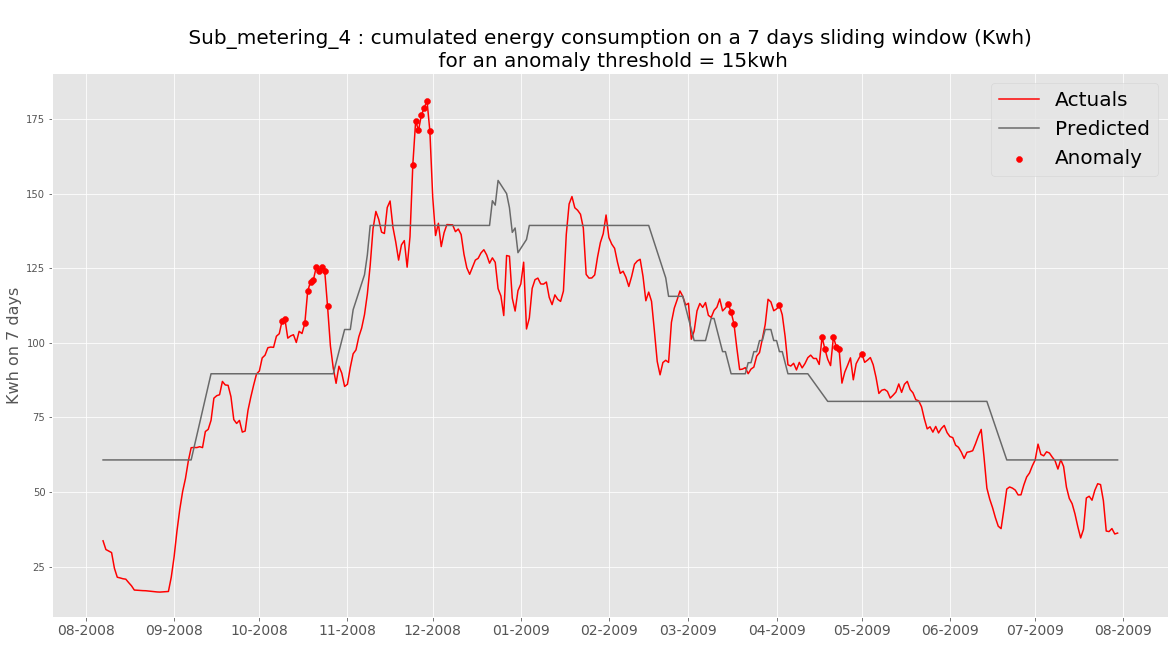

In [51]:
fig, ax = plt.subplots(figsize=(20,10))

x = df_results.index.values
#pyplot.xlim = [min(x), max(x)]

plt.plot(x,df_results['Actuals']/1000,label='Actuals', color='red')
plt.plot(x,df_results['Predicted']/1000, label='Predicted', color = 'dimgrey')
plt.scatter(df_anomalies.index.values,df_anomalies['Actuals']/1000, color='red', label='Anomaly')
plt.legend(loc='upper right', fontsize=20)
plt.title('\n Sub_metering_4 : cumulated energy consumption on a 7 days sliding window (Kwh) \n for an anomaly threshold = 15kwh', fontsize=20)
# format the ticks

months = mdates.MonthLocator()  # every month
dates_fmt = mdates.DateFormatter('%m-%Y')
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(dates_fmt)
plt.xticks(fontsize=14)

ax.set_ylabel('Kwh on 7 days', fontsize=16)
plt.show()

# Code for collecting temperatures from external API

In [52]:
# get temperature data from darkskynet
def get_temperatures(day_date) :
    
    key_1 = 'bd52bef2813fc642c927b34a11723aea'  # max 1000 requets per day
    
    # base_url variable to store url 
    base_url = "https://api.darksky.net/forecast/"+ key_1 + "/48.7833,2.2833,"

    complete_url = base_url + str(day_date) + "?exclude=currently,minutely,hourly,alerts"

    response = requests.get(complete_url) 

    x = response.json() 

    min_temperature = x["daily"]["data"][0]["temperatureLow"]
    max_temperature = x["daily"]["data"][0]["temperatureHigh"]

    return [day_date, min_temperature,max_temperature]



# store temperature data for our perido of time
def store_temperatures(dataset) : 

    temperatures = []
    
    days = dataset.resample('D').sum().index.astype('int64').values // 10**9

    for day_date in days[800:802] : # limited to 1000 resquets per day
        temperatures.append(get_temperatures(day_date))
    
    df_temperatures = pd.DataFrame(data=temperatures, columns = ['day_date', 'min_temperature', 'max_temperature']).set_index('day_date')
    df_temperatures.index = pd.to_datetime(df_temperatures.index, unit='s')
    #df_temperatures.to_csv('daily_temperatures.csv')
    
    return df_temperatures
